In [1]:
import numpy as np 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import pathlib
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
from pathlib import Path
import imghdr
import os
data_dir = "./Datasets/ImageRetrieval/Train/"
# add there all your images file extensions
image_extensions = [".png", ".jpg",".jpeg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            os.remove('./'+str(filepath))
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            os.remove('./'+str(filepath))
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")


In [62]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('./Datasets/ImageRetrieval/Train', batch_size=128,
                                                               label_mode='categorical', image_size=(224, 224), shuffle=False)
# test_ds = tf.keras.preprocessing.image_dataset_from_directory('./Datasets/ImageRetrieval/Test', batch_size=128,
#                                                                label_mode='categorical', image_size=(224, 224), seed=1)
# val_ds = tf.keras.preprocessing.image_dataset_from_directory('./Datasets/ImageRetrieval/Valid', batch_size=128,
#                                                              label_mode='categorical', image_size=(224, 224), seed=1)


Found 14811 files belonging to 10 classes.


In [63]:
train_ds.class_names

['Baked Potato',
 'Burger',
 'Crispy Chicken',
 'Donut',
 'Fries',
 'Hot Dog',
 'Pizza',
 'Sandwich',
 'Taco',
 'Taquito']

In [65]:
def format_image(image, label, paths):
    image = tf.image.resize(image, (224, 224))/255.0

    image = preprocess_input(image)
    return image, label,  tf.constant(paths)


In [66]:
train_ds = train_ds.map(lambda images, labels: format_image(images, labels, paths = train_ds.file_paths))
# test_ds = test_ds.map(format_image)
# val_ds = val_ds.map(format_image)


## Third pooling layer features

In [6]:
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input,
              outputs=base_model.get_layer('block3_pool').output)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [61]:
train_ds.class_names


['Baked Potato',
 'Burger',
 'Crispy Chicken',
 'Donut',
 'Fries',
 'Hot Dog',
 'Pizza',
 'Sandwich',
 'Taco',
 'Taquito']

In [67]:
from tqdm import tqdm
train_features = [[],[]]
path_index = 0
for items, images, paths in tqdm(train_ds):   
  current_paths = tf.constant(paths)
  predictions = model.predict(items, verbose=False)
  for prediction in predictions:
    path = tf.get_static_value(paths[path_index]).decode("utf-8")
    train_features[0].append(prediction.flatten())
    train_features[1].append(path)
    if(path_index == 0):
      print(images[path_index])
      print(paths[path_index])
    path_index += 1


  0%|          | 0/116 [00:00<?, ?it/s]

tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor(b'./Datasets/ImageRetrieval/Train\\Baked Potato\\Baked Potato-Train (1).jpeg', shape=(), dtype=string)


100%|██████████| 116/116 [01:03<00:00,  1.84it/s]


In [54]:
train_features[1][1]


'./Datasets/ImageRetrieval/Train\\Burger\\Burger-Train (280).jpeg'

In [13]:
len(train_features)

14811

In [ ]:
val_features = []
for items in tqdm(val_ds):
  predictions = model.predict(items[0])
  for prediction in predictions:
    val_features.append(prediction.flatten())


In [ ]:
test_features = []
for items in tqdm(test_ds):
  predictions = model.predict(items[0])
  for prediction in predictions:
    test_features.append(prediction)


In [ ]:
full_dataset = np.concatenate((train_features, val_features))


In [9]:
import pickle

# with open('./Datasets/ImageRetrieval/ProcessedFeatures/train_feat_pool3.pkl', 'wb') as f:
#   pickle.dump(train_features, f)
# with open('./Datasets/ImageRetrieval/ProcessedFeatures/test_feat_pool3.pkl', 'wb') as f:
#   pickle.dump(test_features, f)
with open('./Datasets/ImageRetrieval/ProcessedFeatures/val_feat_pool3.pkl', 'wb') as f:
  pickle.dump(val_features, f)


In [2]:
import pickle

with open('./Datasets//ImageRetrieval/ProcessedFeatures/train_feat_pool3.pkl', 'rb') as f:
  train_features = pickle.load(f)
# with open('./ImageRetrieval/ProcessedFeatures/test_feat_pool3.pkl', 'rb') as f:
#   test_features = pickle.pickle.load(f)
# with open('./Datasets//ImageRetrieval/ProcessedFeatures/val_feat_pool3.pkl', 'rb') as f:
#   val_features = pickle.load(f)


In [6]:
full_dataset = np.concatenate((train_features, val_features))

In [7]:
from sklearn.neighbors import KDTree

tree = KDTree(train_features)


In [ ]:
import pickle

with open('./kb_tree.pkl','wb') as f:
  pickle.dump(tree, f)

In [68]:
import numpy as np
from tqdm import tqdm
from scipy.spatial import distance
from sklearn import metrics
import matplotlib.pyplot as plt

train_features = np.array(train_features)
def format_image(image):
    image = tf.image.resize(image, (224, 224))/255.0
    image = preprocess_input(image)
    image_exp = np.expand_dims(image, axis=0).copy()
    print(image_exp.shape)
    return image_exp
def search_image(img_path, model):
  
  image = tf.keras.preprocessing.image.load_img(img_path)
  image = tf.keras.preprocessing.image.img_to_array(image)
  copy_image = image.copy()
  formatted_img = format_image(image)
  features = model.predict([formatted_img])
  print(train_features[0][0].shape)
  extr_feature = features[0]
  extr_feature = extr_feature.flatten()
  dists = [distance.euclidean(x, extr_feature) for x in train_features[0]]

  # for item in tqdm(train_features[0]):
  #   distsance = distance.euclidean(item, extr_feature )
  #   dists.append(distance)
  print(dists[0])
  ids = np.argsort(dists)[:10]
  print(ids)
  fig = plt.figure(figsize=(8, 8))


  axes = []

  for a in range(5*2):
      score = ids[a]
      axes.append(fig.add_subplot(5, 2, a+1))
      plt.axis('off')
      plt.imshow(tf.keras.preprocessing.image.load_img(
          train_features[1][score], color_mode='rgb'))
  fig.tight_layout()
  plt.show()
  return
  scores = [(dists[id], train_features[1][id]) for id in ids]
  print(scores)


C:\Users\Ruben\AppData\Local\Temp\ipykernel_20704\2550675593.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_features = np.array(train_features)


In [ ]:
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input,
              outputs=base_model.get_layer('block3_pool').output)



(1, 224, 224, 3)
1/1 [==============================] - 0s 382ms/step
(200704,)
7335.34912109375
[ 2878  4022  2751  1748  3873 11365  7446  1612  2570  7033]


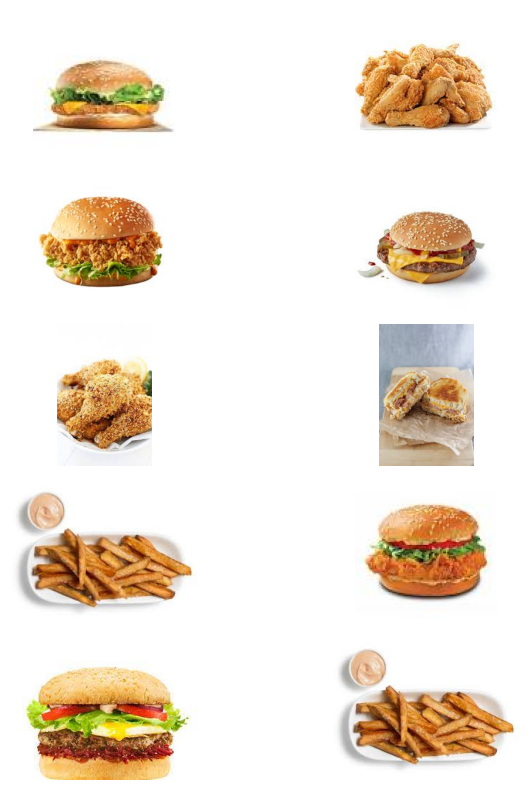

In [69]:
search_image(
    './Datasets/ImageRetrieval/Test/Burger/Burger-Test (2).jpeg', model)


## Last pooling layer features